In [1]:
#math and linear algebra stuff
import numpy as np
import numpy.linalg as la
import scipy as sc

#plots
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15.0, 15.0)
#mpl.rc('text', usetex = True)
import matplotlib.pyplot as plt
%matplotlib inline

# Chebyshev Polynomial Acceleration

This notebook intend to study the roots of the so called "Chebyshev Polynomial Acceleration" that encountered a large success in the field of first order optimization method acceleration.

## Chebyshev Polynomial : Introduction

### Definition

Tchebychev polynomial $T_n$ of the first kind is defined this way :

\begin{equation}
 \forall \Theta \in \mathbb{R}, T_n( cos( \Theta) ) = cos( n \theta)
\end{equation}

It is defined over $[-1,1]$, and using Newton's binomial formula we make the following derivation:

\begin{align*}
  cos( n \Theta ) &= \operatorname{Re}( (cos(\Theta)+j sin(\Theta))^n ) \\
  &= \operatorname{Re} \left( \sum_{k=0}^{n} \binom{n}{k} cos(\Theta)^{n-k} (i sin(\Theta))^k \right) \\
  &= \sum_{p=0}^{\lfloor n/2 \rfloor} \binom{n}{2p} (-1)^p cos(\Theta)^{n-2p} sin(\Theta)^{2p} \\
  &= \sum_{p=0}^{\lfloor n/2 \rfloor} \binom{n}{2p} cos(\Theta)^{n-2p} (-1)^p (1-cos(\Theta)^2)^{p} \\
  &= \sum_{p=0}^{\lfloor n/2 \rfloor} \binom{n}{2p} cos(\Theta)^{n-2p} (cos(\Theta)^2 -1)^{p}
\end{align*}
 
Identifying $cos( \Theta )$ gives the following degree-n polynomial in x:

\begin{equation}
 T_n(x) =  \sum_{p=0}^{\lfloor n/2 \rfloor} \binom{n}{2p} x^{n-2p} (x^2-1)^{p} , \forall x \in [-1,1]
\end{equation}

This expression is not trivial, but we know that at least it has a closed form that can be numerically computed if needed.

Most of the properties of the Tchebychev polynomial will come from its recurrence definition:

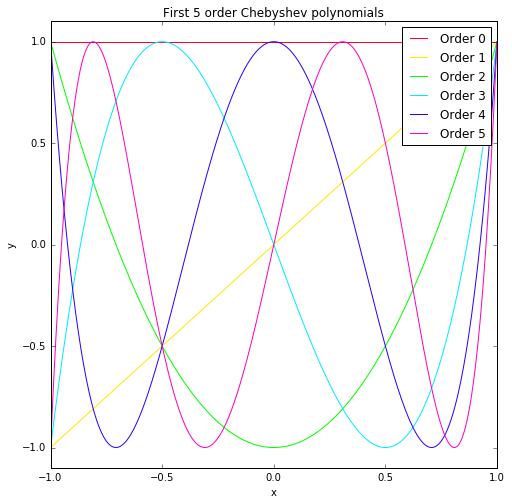

In [23]:
"""
Draw all Chebyshev Polynomial up to order 5 over
the range [-1,1]
"""

from math import factorial
from scipy import misc as misc

def comb(n, k):
    return misc.comb(n,k)
    #return factorial(n) / (factorial(k) * factorial(n - k))

ChebyOrderMax = 5
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/ChebyOrderMax) for i in range(ChebyOrderMax+1)]
plt.figure(figsize=(8,8))
plt.title( "First "+str(ChebyOrderMax)+" order Chebyshev polynomials")
x = np.linspace(-1,1,500)
plt.xlabel("x")
plt.ylabel("y")
ax = plt.subplot()
ax.set_ylim([-1.1,1.1])

def Cheby(x, order):
    y=[comb(order,2*i)*
       x**(order-2*i)*(x**2-1)**i
       for i in range(order//2+1)]
    return np.sum(y,axis=0)

for color,order in zip(colors, range(ChebyOrderMax+1)):
    plt.plot(x,Cheby(x,order),color=color,label="Order "+str(order))

plt.legend()

### Recurrence relation

From the previous expression of $cos( n \Theta )$ we can retrieve a simple property, well known from the field of signal processing, and related to the modulation of real signal.
This property can also be derived using linearity of Fourier transform:

\begin{equation}
  \begin{split}
 cos(\Theta) cos( (n+1) \Theta ) 	&= \frac{1}{2} ( cos( n \Theta ) + cos( (n+2) \Theta ) ) \\
 2 cos(\Theta) cos( (n+1) \Theta ) 	&= cos( n \Theta ) + cos( (n+2) \Theta ) \\
 2 cos(\Theta) T_{n+1}(cos(\Theta)) 	&= T_n(cos(\Theta)) + T_{n+2}(cos(\Theta))
  \end{split}
\end{equation}

In [25]:
"""
Check numerically that recursion relation is valid
"""
ChebyOrderMax = 1
x = np.linspace(-1,1,500)
for order in range(ChebyOrderMax+1):
     assert(np.allclose(Cheby(x,order+2),2*x*Cheby(x,order+1)-Cheby(x,order)))
    

SyntaxError: invalid syntax (<ipython-input-25-e9525d75d418>, line 7)

Identifying $cos( \Theta )$ gives the following recurrence relation in x:

\begin{equation}
    T_{n+2}(x) = -T_n(x) + 2 x T_{n+1}(x) , \forall x \in [-1,1]
\end{equation}

From this relation, we can easily show that $ \frac{1}{2^{n-1}} T_n(x) $, with $ n \geq 1 $ is a degree-n monic polynomial, i.e a polynomial of leading coefficient 1. Let's make a recurrence reasonning:\\

\begin{equation}
  \begin{split}
 T_0(x) &= 1\\
 \frac{1}{2^{1-1}} T_1(x) &= x \\
 \frac{1}{2^{2-1}} T_2(x) &=  \frac{1}{2} \times 2 x^{2} - 1 \\
 \frac{1}{2^{2-1}} T_2(x) &=  x^{2} - 1
 \end{split}
\end{equation}

For $n = 1$ and $n = 2$, we can see that $ \frac{1}{2^{n-1}} T_n(x) $ is a degree-n monic polynomial.
We can see that the only $x^{n+2}$ degree term in $T_{n+2}$ comes from $ 2 x T_{n+1}(x) $, so if $T_{n+1}(x)$ is a monic polynomial, then its leading term is $x^{n+1}$

Let's define $t_n(x)$ as  $ \frac{1}{2^{n-1}} T_n(x) $ for $n \geq 1$, we have then

\begin{equation}
  \begin{split}
    \frac{1}{2^{(n+2)-1}} T_{n+2}(x) &= \frac{1}{2^{(n+2)-1}} \times \left( -T_n(x) + 2 x T_{n+1}(x) \right) \\
    t_{n+2}(x) &= \frac{1}{4} \times t_n(x) + x t_{n+1}(x)
 \end{split}
\end{equation}

Keeping only $n+2$ degree terms gives

\begin{equation}
    \left(t_{n+2}(x)\right)_{degree n+2)} = x \left(t_{n+1}(x)\right)_{degree n+1)}
\end{equation}

The leading coefficient of $t_{n+2}(x)$ is then the same as the one of $t_{n+1}(x)$, which is equal to 1 in $t_1$ and $t_2$, and then lead to our recursive proof.

### Chebyshev Polynomial as Differential Equation Solution

Tchebychev Polynomial may have a role in certain differential equation solution, let's take a short insight at what differential equation can be derived from the definition of $T_n$, where it can be a solution:

Let's take again our first expression for the Tchebychev polynomial, and let's try to derive it:
	
\begin{equation}
  \begin{split}
    T_n( cos(\Theta) ) &= cos( n \theta) \\
    (T_n( cos(\Theta)))' &= cos(n \theta)' \\
    -sin(\Theta) T_n'(cos(\Theta)) &= -n sin(n \theta)
 \end{split}
\end{equation}

Then derive this expression one more time to make $T_n( cos(\Theta) )$ to appear again on the right hand side

\begin{equation}
  \begin{split}
 (-sin(\Theta) T_n'(cos(\Theta)))' &= (-n sin(n \theta))' \\
 -cos(\Theta) T_n'(cos(\Theta)) -sin(\Theta)T_n^{\prime\prime}(cos(\Theta))(-sin(\Theta)) &= - n^2 cos(n \theta) \\
 -cos(\Theta) T_n'(cos(\Theta)) + sin(\Theta)^2 T_n^{\prime\prime}(cos(\Theta)) &= -n^2 T_n(cos(\theta))
 \end{split}
\end{equation}

Identifying $cos( \Theta )$ gives the following differential equation in $x$ and $f$ for which $T_{n}$ is a solution:

\begin{equation}
    n^2 f(x) -x f'(x) + (1-x)^2 f^{\prime\prime}(x) = 0 , \forall x \in [-1,1]
\end{equation}

It could be noticed that this differential equation is a special case of Sturm–Liouville differential equations.

### Introduction : approximating a constant function
	
To understand the role of Tchebychev Polynomial, in the framework of approximation theory, we must first understand that $T_n$ could be use to design the best uniform approximation of the constant functions 0 over $[-1,1]$ among the set of all degree-n monic polynomial

let's define

\begin{equation}
    t_n(x) = \frac{1}{2^{n-1}} T_n(x) , \forall x \in [-1,1]
\end{equation}

#### Optimality
	
We would like to show that, for any monic polynomial $P(x)$ of degree $ n \geq 1 $ we have:

\begin{align*}
	  \| t_n(x) \|_{\infty, x \in [-1,1]} = \frac{1}{2^{n-1}} \leq \| P(x) \|_{\infty, x \in [-1,1]} , \forall x \in [-1,1]
\end{align*}

Where $\|.\|_{\infty, x \in [-1,1]}$ is defined over $ [-1,1] $ as a uniform maximum distance $max( |x| )$.

Let's suppose that

\begin{equation}
   \| P(x) \|_{\infty, x \in [-1,1]} < \frac{1}{2^{n-1}} = \| t_n(x) \|_{\infty, x \in [-1,1]}
\end{equation}

And let's consider $x_k = cos( \frac{k \pi}{n} ), 0 \leq k < n$ such that

\begin{align*}
  t_n(x_0) &= \frac{1}{2^{n-1}} &> P(x_0) \\
  t_n(x_1) &= \frac{-1}{2^{n-1}} &< P(x_1) \\
  t_n(x_2) &= \frac{1}{2^{n-1}} &> P(x_2) \\
  \vdots & \vdots	&	\vdots \\
  t_n(x_{n-1}) &= \frac{(-1)^{n-1}}{2^{n-1}} & \dots \\
\end{align*}
    
It is clear that the polynomial $t_n(x) - P(x)$ sees its sign change in every interval $]x_k,x_{k+1}[ , 0 \leq k < n-1 $ so it should possess $n$ distincts roots.

But, as $P$ and $t_n$ are degree-n monic polynomial, their difference should be a degree n-1 or less polynomial, $t_n(x) - P(x)$ is then reduced to 0, which is in contradiction with the initial inequality $ \| P(x) \|_{\infty} < \| t_n(x) \|_{\infty} $
	
So we have

\begin{align*}
    &\text{For all degree n } \geq 1 \text{ monic polynomial } P, \\
    &\| P(x) \|_{\infty, x \in [-1,1]} \geq \frac{1}{2^{n-1}} \\
    &\text{ And this optimality bound is achieved using Tchebychev Polynomial :}\\
    &\| \frac{1}{2^{n-1}} T_n(x) \|_{\infty, x \in [-1,1]} =  \frac{1}{2^{n-1}}
\end{align*}

#### Unicity

Now, we would like to show that $t_n(x)$ is the unic monic polynomial of degree n that satisfies $\| P(x) \|_{\infty, x \in [-1,1]} = \frac{1}{2^{n-1}}$

So let's take $P(x)$ defined over $[-1,1]$ such that $\| P(x) \|_{\infty, x \in [-1,1]} = \frac{1}{2^{n-1}}$, then $Q(x) = t_n(x)-P(x)$ and $L_Q$ the Lagrange polynomial interpolation of $Q$ over the $n+1$ points $x_k, 0 \leq k \leq n$ defined earlier.

$L_Q(x)$ can be expressed as:

\begin{align*}
 L_Q(x) = \sum_{k=0}^{n} \lambda_k \left( \prod_{i=0,i\neq k}^{n} (x-x_i) \right)
\end{align*}

where

\begin{align*}
 \lambda_j = \frac{Q(x_j)}{\prod_{i=0,i\neq j}^{n}(x_j-x_i)}
\end{align*}

As seen in the existence part, we know that we are looking for an optimal polynomial $P(x)$ that should verify

\begin{align*}
    &\| P(x) \|_{\infty, x \in [-1,1]} \leq \frac{1}{2^{n-1}} \\
    \Leftrightarrow &\frac{-1}{2^{n-1}} \geq P(x) \geq \frac{1}{2^{n-1}}
\end{align*}

Then we can say, that, evaluated in the $x_k, 0 \geq k \geq n$, we have

\begin{equation}
    t_n(x_k) = \frac{(-1)^k}{2^{n-1}}
    \begin{cases}
      \geq P(x_k) \text{ when } (-1)^k > 0 \\
      \leq P(x_k) \text{ when } (-1)^k < 0
    \end{cases}
\end{equation}

So, when looking at the sign of the difference between the two polynomial

\begin{equation}
    t_n(x_k) - P(x_k)
    \begin{cases}
      \geq 0 \text{ when } (-1)^k > 0\\
      \leq 0 \text{ when } (-1)^k < 0
    \end{cases}
\end{equation}

and

\begin{align*}
  (-1)^k \left( t_n(x_k) - P(x_k) \right) &\geq 0 , \forall k \in (0,1,\dots,n) \\
  (-1)^k Q(x_k) &\geq 0 , \forall k \in (0,1,\dots,n)
\end{align*}

Lets take a look at what happen to the denominator of $\lambda_k$ :

\begin{equation}
    \prod_{i=0,i\neq k}^{n}(x_k-x_i)
\end{equation}

As the $x_k, 0 \geq k \geq n$ are strictly decreasing from $1$ to $-1$, the previous product contains k terms where $x_k-x_i$ is negative because $i < k$ and $x_i>x_k$.

The other $n-k$ terms being positive, the sign of the product only depends on $k$ as $(-1)^k$ , we then have:

\begin{equation}
    (-1)^k \prod_{i=0,i\neq k}^{n}(x_k-x_i) \geq 0
\end{equation}

Hence, $ \lambda_k \geq 0 \forall k \in (0,1,\dots,n) $

As $Q(x)$ and $L_Q(x)$ are equal in $n+1$ points, and as they are of degree at most n, they are equal, and $Q$ as a difference of monic polynomial of degree $n$ is of degree $n-1$.

The equality between $Q(x)$ and $L_Q(x)$ results in $L_Q(x)$ being also of degree $n-1$, hence, analysing the expression of the coefficient related to $x^k$ in $L_Q$ gives:

\begin{equation}
    \sum_{k=0}^{n} \lambda_k = 0
\end{equation}

As seen previously, as $ \lambda_k \geq 0 \forall k \in (0,1,\dots,n) $, we have $ \lambda_k = 0 \forall k \in (0,1,\dots,n) $ hence, the conclusion:
The best uniform approximation of the constant functions 0 over $[-1,1]$ among the degree-n monic polynomial is the Chebyshev Polynomial.